🔍 ANALYZING SPAN OVERLAPS ACROSS DATASETS

📁 Analyzing Training...
✓ Successfully loaded dataset from: ./train.json
   Found 84 overlapping span pairs

📁 Analyzing Validation...
✓ Successfully loaded dataset from: ./validation.json
   Found 28 overlapping span pairs

📁 Analyzing Test...
✓ Successfully loaded dataset from: ./test.json
   Found 10 overlapping span pairs
🔍 SPAN OVERLAP ANALYSIS SUMMARY

📊 OVERVIEW:
  Total overlapping span pairs: 122
  Samples with overlaps: 35
  Datasets affected: Test, Training, Validation

📈 OVERLAP SEVERITY:
  Minor Overlap: 0 (0.0%)
  Moderate Overlap: 0 (0.0%)
  Major Overlap: 0 (0.0%)
  Severe Overlap: 122 (100.0%)

🏷️  MOST COMMON OVERLAPPING LABEL PAIRS:
  DATUM ↔ HAUSNUMMER: 23 overlaps
  NACHNAME ↔ NACHNAME: 22 overlaps
  HAUSNUMMER ↔ ZÄHLERNUMMER: 15 overlaps
  HAUSNUMMER ↔ VERTRAGSNUMMER: 13 overlaps
  HAUSNUMMER ↔ POSTLEITZAHL: 12 overlaps
  HAUSNUMMER ↔ TELEFONNUMMER: 10 overlaps
  DATUM ↔ DATUM: 6 overlaps
  WOHNORT ↔ WOHNORT: 4 overlaps
 

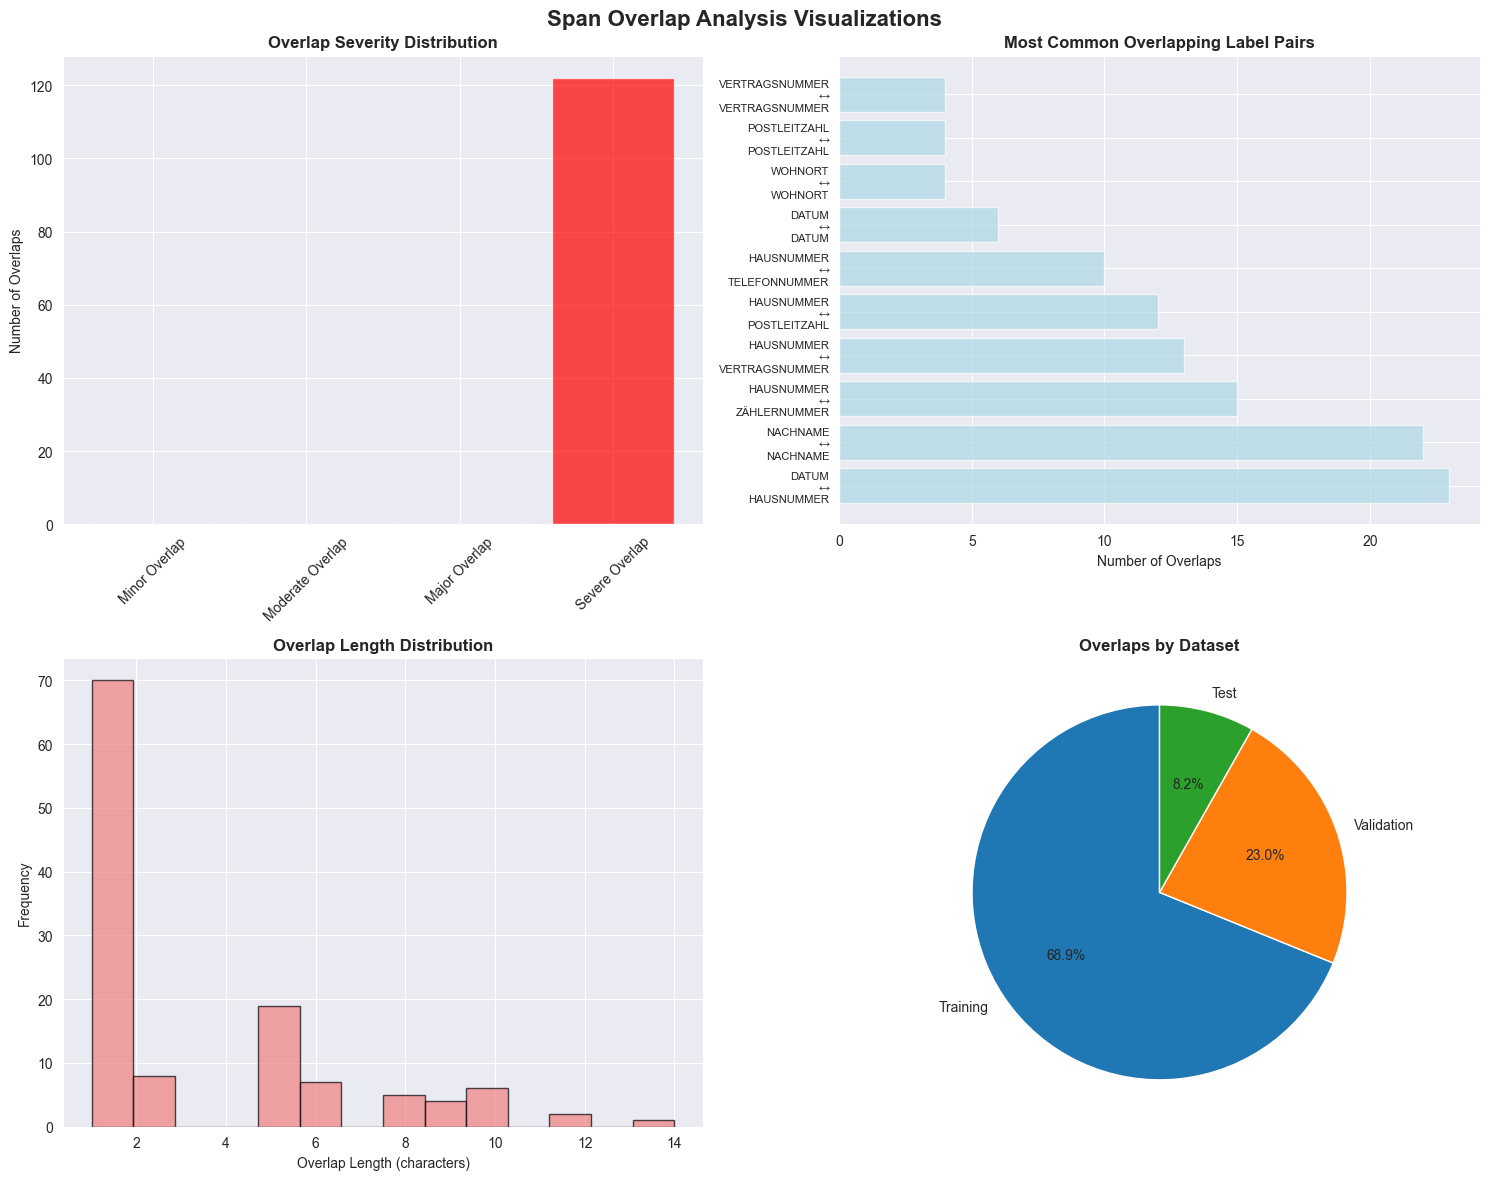


📋 DETAILED OVERLAP RESULTS:
--------------------------------------------------
   Dataset Sample_File  Sample_Index        Label_1  Span_1                                             Text_1        Label_2  Span_2         Text_2   Overlap_Text  Overlap_Length Overlap_Percent_1 Overlap_Percent_2
  Training       1.txt             0 VERTRAGSNUMMER   53-62                                          406027919     HAUSNUMMER   57-58              2              2               1             11.1%            100.0%
  Training       7.txt             3          DATUM 170-180                                         14.09.1958     HAUSNUMMER 178-179              5              5               1             10.0%            100.0%
  Training       7.txt             3   ZÄHLERNUMMER 223-228                                              12543     HAUSNUMMER 225-226              5              5               1             20.0%            100.0%
  Training      12.txt             8   ZÄHLERNUMMER   64

In [1]:
# Span Overlap Analysis Notebook
# Analyze overlapping spans in labeled datasets

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Set
from collections import defaultdict
import os

def load_dataset(file_path: str) -> List[Dict]:
    """Load JSON dataset from file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✓ Successfully loaded dataset from: {file_path}")
        return data
    except FileNotFoundError:
        print(f"❌ Error: File not found at {file_path}")
        return []
    except json.JSONDecodeError as e:
        print(f"❌ Error: Invalid JSON format - {e}")
        return []
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return []

def check_span_overlap(span1: Dict, span2: Dict) -> bool:
    """Check if two spans overlap."""
    start1, end1 = span1['start'], span1['end']
    start2, end2 = span2['start'], span2['end']

    # Two spans overlap if one starts before the other ends
    return not (end1 <= start2 or end2 <= start1)

def get_overlap_details(span1: Dict, span2: Dict) -> Dict:
    """Get detailed information about the overlap between two spans."""
    start1, end1 = span1['start'], span1['end']
    start2, end2 = span2['start'], span2['end']

    # Calculate overlap boundaries
    overlap_start = max(start1, start2)
    overlap_end = min(end1, end2)
    overlap_length = overlap_end - overlap_start

    # Calculate overlap percentages
    span1_length = end1 - start1
    span2_length = end2 - start2
    overlap_percent_span1 = (overlap_length / span1_length) * 100 if span1_length > 0 else 0
    overlap_percent_span2 = (overlap_length / span2_length) * 100 if span2_length > 0 else 0

    return {
        'overlap_start': overlap_start,
        'overlap_end': overlap_end,
        'overlap_length': overlap_length,
        'overlap_percent_span1': overlap_percent_span1,
        'overlap_percent_span2': overlap_percent_span2
    }

def analyze_overlaps_in_sample(sample: Dict, dataset_name: str, sample_index: int) -> List[Dict]:
    """Analyze overlapping spans within a single sample."""
    labels = sample.get('labels', [])
    overlaps = []

    # Check all pairs of labels for overlaps
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            span1 = labels[i]
            span2 = labels[j]

            if check_span_overlap(span1, span2):
                overlap_details = get_overlap_details(span1, span2)

                # Extract text snippets
                text = sample.get('text', '')
                span1_text = text[span1['start']:span1['end']]
                span2_text = text[span2['start']:span2['end']]
                overlap_text = text[overlap_details['overlap_start']:overlap_details['overlap_end']]

                overlap_info = {
                    'dataset': dataset_name,
                    'sample_index': sample_index,
                    'sample_file': sample.get('file', f'sample_{sample_index}'),
                    'text_preview': text[:100] + '...' if len(text) > 100 else text,
                    'span1_label': span1['label'],
                    'span1_start': span1['start'],
                    'span1_end': span1['end'],
                    'span1_text': span1_text,
                    'span2_label': span2['label'],
                    'span2_start': span2['start'],
                    'span2_end': span2['end'],
                    'span2_text': span2_text,
                    'overlap_text': overlap_text,
                    **overlap_details
                }

                overlaps.append(overlap_info)

    return overlaps

def analyze_dataset_overlaps(data: List[Dict], dataset_name: str) -> List[Dict]:
    """Analyze all overlapping spans in a dataset."""
    all_overlaps = []

    for i, sample in enumerate(data):
        sample_overlaps = analyze_overlaps_in_sample(sample, dataset_name, i)
        all_overlaps.extend(sample_overlaps)

    return all_overlaps

def create_overlap_summary(overlaps: List[Dict]) -> Dict:
    """Create a summary of overlap statistics."""
    if not overlaps:
        return {
            'total_overlaps': 0,
            'samples_with_overlaps': 0,
            'datasets_affected': set(),
            'label_pairs': {},
            'overlap_types': {}
        }

    # Basic statistics
    total_overlaps = len(overlaps)
    samples_with_overlaps = len(set((o['dataset'], o['sample_index']) for o in overlaps))
    datasets_affected = set(o['dataset'] for o in overlaps)

    # Label pair analysis
    label_pairs = defaultdict(int)
    for overlap in overlaps:
        pair = tuple(sorted([overlap['span1_label'], overlap['span2_label']]))
        label_pairs[pair] += 1

    # Overlap type analysis (by overlap percentage)
    overlap_types = {
        'minor_overlap': 0,      # < 25% overlap
        'moderate_overlap': 0,   # 25-50% overlap
        'major_overlap': 0,      # 50-75% overlap
        'severe_overlap': 0      # > 75% overlap
    }

    for overlap in overlaps:
        max_overlap_percent = max(overlap['overlap_percent_span1'], overlap['overlap_percent_span2'])
        if max_overlap_percent < 25:
            overlap_types['minor_overlap'] += 1
        elif max_overlap_percent < 50:
            overlap_types['moderate_overlap'] += 1
        elif max_overlap_percent < 75:
            overlap_types['major_overlap'] += 1
        else:
            overlap_types['severe_overlap'] += 1

    return {
        'total_overlaps': total_overlaps,
        'samples_with_overlaps': samples_with_overlaps,
        'datasets_affected': datasets_affected,
        'label_pairs': dict(label_pairs),
        'overlap_types': overlap_types
    }

def print_overlap_summary(summary: Dict):
    """Print a summary of overlap analysis."""
    print("=" * 60)
    print("🔍 SPAN OVERLAP ANALYSIS SUMMARY")
    print("=" * 60)

    print(f"\n📊 OVERVIEW:")
    print(f"  Total overlapping span pairs: {summary['total_overlaps']}")
    print(f"  Samples with overlaps: {summary['samples_with_overlaps']}")
    print(f"  Datasets affected: {', '.join(summary['datasets_affected']) if summary['datasets_affected'] else 'None'}")

    if summary['total_overlaps'] > 0:
        print(f"\n📈 OVERLAP SEVERITY:")
        overlap_types = summary['overlap_types']
        for overlap_type, count in overlap_types.items():
            percentage = (count / summary['total_overlaps']) * 100
            print(f"  {overlap_type.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")

        print(f"\n🏷️  MOST COMMON OVERLAPPING LABEL PAIRS:")
        sorted_pairs = sorted(summary['label_pairs'].items(), key=lambda x: x[1], reverse=True)
        for (label1, label2), count in sorted_pairs[:10]:  # Top 10
            print(f"  {label1} ↔ {label2}: {count} overlaps")

    if summary['total_overlaps'] == 0:
        print(f"\n✅ No overlapping spans found!")

def create_overlap_dataframe(overlaps: List[Dict]) -> pd.DataFrame:
    """Create a pandas DataFrame from overlap data."""
    if not overlaps:
        return pd.DataFrame()

    # Select relevant columns for the DataFrame
    df_data = []
    for overlap in overlaps:
        df_data.append({
            'Dataset': overlap['dataset'],
            'Sample_File': overlap['sample_file'],
            'Sample_Index': overlap['sample_index'],
            'Label_1': overlap['span1_label'],
            'Span_1': f"{overlap['span1_start']}-{overlap['span1_end']}",
            'Text_1': overlap['span1_text'],
            'Label_2': overlap['span2_label'],
            'Span_2': f"{overlap['span2_start']}-{overlap['span2_end']}",
            'Text_2': overlap['span2_text'],
            'Overlap_Text': overlap['overlap_text'],
            'Overlap_Length': overlap['overlap_length'],
            'Overlap_Percent_1': f"{overlap['overlap_percent_span1']:.1f}%",
            'Overlap_Percent_2': f"{overlap['overlap_percent_span2']:.1f}%"
        })

    return pd.DataFrame(df_data)

def create_overlap_visualizations(overlaps: List[Dict], summary: Dict):
    """Create visualizations for overlap analysis."""
    if not overlaps:
        print("No overlaps found - no visualizations to create.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Span Overlap Analysis Visualizations', fontsize=16, fontweight='bold')

    # 1. Overlap types distribution
    overlap_types = summary['overlap_types']
    types = list(overlap_types.keys())
    counts = list(overlap_types.values())

    axes[0, 0].bar([t.replace('_', ' ').title() for t in types], counts,
                   color=['lightgreen', 'yellow', 'orange', 'red'], alpha=0.7)
    axes[0, 0].set_title('Overlap Severity Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Number of Overlaps')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Most common overlapping label pairs
    label_pairs = summary['label_pairs']
    sorted_pairs = sorted(label_pairs.items(), key=lambda x: x[1], reverse=True)[:10]

    if sorted_pairs:
        pairs, pair_counts = zip(*sorted_pairs)
        pair_labels = [f"{p[0]}\n↔\n{p[1]}" for p in pairs]

        axes[0, 1].barh(range(len(pairs)), pair_counts, color='lightblue', alpha=0.7)
        axes[0, 1].set_title('Most Common Overlapping Label Pairs', fontweight='bold')
        axes[0, 1].set_xlabel('Number of Overlaps')
        axes[0, 1].set_yticks(range(len(pairs)))
        axes[0, 1].set_yticklabels(pair_labels, fontsize=8)

    # 3. Overlap length distribution
    overlap_lengths = [o['overlap_length'] for o in overlaps]
    axes[1, 0].hist(overlap_lengths, bins=min(20, max(overlap_lengths)),
                    color='lightcoral', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Overlap Length Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Overlap Length (characters)')
    axes[1, 0].set_ylabel('Frequency')

    # 4. Overlaps by dataset
    dataset_counts = defaultdict(int)
    for overlap in overlaps:
        dataset_counts[overlap['dataset']] += 1

    datasets = list(dataset_counts.keys())
    counts = list(dataset_counts.values())

    axes[1, 1].pie(counts, labels=datasets, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Overlaps by Dataset', fontweight='bold')

    plt.tight_layout()
    plt.show()

def analyze_overlap_patterns(overlaps: List[Dict]):
    """Analyze patterns in overlapping spans."""
    if not overlaps:
        return

    print(f"\n🔍 DETAILED OVERLAP PATTERNS:")
    print("-" * 50)

    # Group by dataset
    dataset_overlaps = defaultdict(list)
    for overlap in overlaps:
        dataset_overlaps[overlap['dataset']].append(overlap)

    for dataset, dataset_overlaps_list in dataset_overlaps.items():
        print(f"\n📁 {dataset.upper()}:")
        print(f"   Total overlaps: {len(dataset_overlaps_list)}")

        # Show some examples
        for i, overlap in enumerate(dataset_overlaps_list[:3]):  # Show first 3 examples
            print(f"\n   Example {i+1}:")
            print(f"     File: {overlap['sample_file']}")
            print(f"     Labels: {overlap['span1_label']} ↔ {overlap['span2_label']}")
            print(f"     Spans: [{overlap['span1_start']}-{overlap['span1_end']}] ↔ [{overlap['span2_start']}-{overlap['span2_end']}]")
            print(f"     Text 1: '{overlap['span1_text']}'")
            print(f"     Text 2: '{overlap['span2_text']}'")
            print(f"     Overlap: '{overlap['overlap_text']}'")
            print(f"     Overlap %: {overlap['overlap_percent_span1']:.1f}% / {overlap['overlap_percent_span2']:.1f}%")

        if len(dataset_overlaps_list) > 3:
            print(f"   ... and {len(dataset_overlaps_list) - 3} more overlaps")

def analyze_multiple_datasets(dataset_paths: List[Tuple[str, str]]) -> Tuple[List[Dict], pd.DataFrame]:
    """Analyze overlaps across multiple datasets."""
    all_overlaps = []

    print("🔍 ANALYZING SPAN OVERLAPS ACROSS DATASETS")
    print("=" * 60)

    for file_path, dataset_name in dataset_paths:
        print(f"\n📁 Analyzing {dataset_name}...")
        data = load_dataset(file_path)
        if data:
            overlaps = analyze_dataset_overlaps(data, dataset_name)
            all_overlaps.extend(overlaps)
            print(f"   Found {len(overlaps)} overlapping span pairs")

    # Create summary and visualizations
    summary = create_overlap_summary(all_overlaps)
    print_overlap_summary(summary)

    if all_overlaps:
        analyze_overlap_patterns(all_overlaps)
        create_overlap_visualizations(all_overlaps, summary)

    # Create DataFrame
    df = create_overlap_dataframe(all_overlaps)

    return all_overlaps, df

# Main analysis function
def main():
    """Main function to run overlap analysis."""

    # Define dataset paths
    dataset_paths = [
        ("./train.json", "Training"),
        ("./validation.json", "Validation"),
        ("./test.json", "Test")
    ]

    # Run analysis
    all_overlaps, df = analyze_multiple_datasets(dataset_paths)

    # Display results
    if not df.empty:
        print(f"\n📋 DETAILED OVERLAP RESULTS:")
        print("-" * 50)
        print(df.to_string(index=False, max_colwidth=50))

        # Save results to CSV
        output_path = "span_overlap_analysis_results.csv"
        df.to_csv(output_path, index=False)
        print(f"\n💾 Results saved to: {output_path}")
    else:
        print(f"\n✅ No overlapping spans found in any dataset!")

    return all_overlaps, df

# Example usage for single dataset
def analyze_single_dataset(file_path: str, dataset_name: str):
    """Analyze overlaps in a single dataset."""
    print(f"🔍 Analyzing overlaps in {dataset_name}")
    print("-" * 50)

    data = load_dataset(file_path)
    if not data:
        return [], pd.DataFrame()

    overlaps = analyze_dataset_overlaps(data, dataset_name)
    summary = create_overlap_summary(overlaps)

    print_overlap_summary(summary)

    if overlaps:
        analyze_overlap_patterns(overlaps)
        create_overlap_visualizations(overlaps, summary)

    df = create_overlap_dataframe(overlaps)

    if not df.empty:
        print(f"\n📋 OVERLAP DETAILS:")
        print(df.to_string(index=False, max_colwidth=50))

    return overlaps, df

if __name__ == "__main__":
    # Run the main analysis
    all_overlaps, results_df = main()

    # Example: Analyze a single dataset
    # overlaps, df = analyze_single_dataset("notebooks/data/granular_dataset_split/train.json", "Training")